# Transfer Learning with MobileNetV2 model

In this notebook, I am going to apply end-to-end transfer learning on EuroSat data with pre-trained MobileNetV2 architecture.

Eurosat is a dataset and deep learning benchmark for land use and land cover classification. The dataset is based on Sentinel-2 satellite images covering 13 spectral bands and consisting out of 10 classes with in total 27,000 labeled and geo-referenced images. You can find out more details about dataset [here](https://github.com/phelber/eurosat)

## Table of content
- [1 - Packages](#1)
    - [1.1  Training and Validation Sets](#1-1)
- [2 - Transfer Learning with MobileNet V2](#2)
- [3 - Fine Tuning of Model](#3)
- [4- Re-compiling with lower learning rate](#4)
- [5- References](#5)

<a name='1'></a>
## 1. Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model

<a name='1-1'></a>
### 1.1 Training and Validation Sets

When training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Call `image_data_set_from_directory()` to read from the directory and create both training and validation datasets. 

You'll also set your seeds to match each other, so your training and validation sets don't overlap. 

In [2]:
directory = '2750' #directory where image dataset is stored
batch_size = 32 #batch size 
image_size = (64,64) #Image height and width

In [3]:
train_ds, val_ds = image_dataset_from_directory(directory,
                                               image_size=image_size,
                                               batch_size=batch_size,
                                                seed=101, #seed to make sure training and validation 
                                               shuffle =True,# have different image datasets
                                               validation_split=0.2,
                                               subset="both")

Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Using 5400 files for validation.


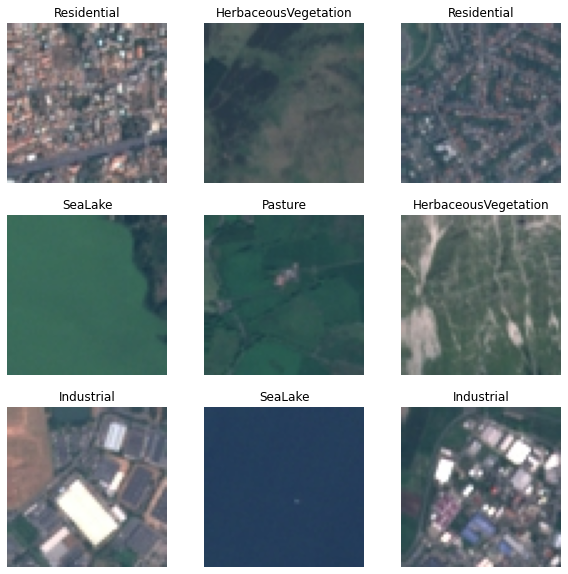

In [4]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

In [5]:
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

<a name='2'></a>
## 2. Transfer Learning With MobileNet V2

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:

*   Depthwise separable convolutions
*   Thin input and output bottlenecks between layers
*   Shortcut connections between bottleneck layers

Key things to remember while using transfer learning:
1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False 
     
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [6]:
def Euro_model(image_shape = image_size, classes = None):
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights="imagenet")
    base_model.trainable = False
    
    X_inputs = tf.keras.Input(shape=input_shape)
    X = tf.keras.layers.Rescaling(1.0/255)(X_inputs)
    
    X= base_model(X, training = False)
    
    X = tf.keras.layers.AveragePooling2D((2, 2))(X) 
    X = tf.keras.layers.Dropout(0.4)(X)    
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(classes, activation='softmax')(X)
    
    
    model = Model(inputs = X_inputs, outputs = X)

    return model

In [7]:
model = Euro_model(image_size, 10)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 1280)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 1, 1, 1280)        0         
                                                                 
 flatten (Flatten)           (None, 1280)              0     

In [9]:
model.compile(optimizer=keras.optimizers.Adam(1e-3),loss="sparse_categorical_crossentropy",
               metrics=["sparse_categorical_accuracy"])

In [10]:
epochs = 20
history = model.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/20
675/675 [==============================] - 116s 163ms/step - loss: 1.0049 - sparse_categorical_accuracy: 0.6757 - val_loss: 0.5741 - val_sparse_categorical_accuracy: 0.8122
Epoch 2/20
675/675 [==============================] - 106s 157ms/step - loss: 0.6484 - sparse_categorical_accuracy: 0.7846 - val_loss: 0.5237 - val_sparse_categorical_accuracy: 0.8294
Epoch 3/20
675/675 [==============================] - 117s 173ms/step - loss: 0.6043 - sparse_categorical_accuracy: 0.7979 - val_loss: 0.5058 - val_sparse_categorical_accuracy: 0.8348
Epoch 4/20
675/675 [==============================] - 108s 160ms/step - loss: 0.5830 - sparse_categorical_accuracy: 0.8081 - val_loss: 0.4980 - val_sparse_categorical_accuracy: 0.8415
Epoch 5/20
675/675 [==============================] - 103s 153ms/step - loss: 0.5796 - sparse_categorical_accuracy: 0.8057 - val_loss: 0.5140 - val_sparse_categorical_accuracy: 0.8343
Epoch 6/20
675/675 [==============================] - 104s 154ms/step - loss: 0.

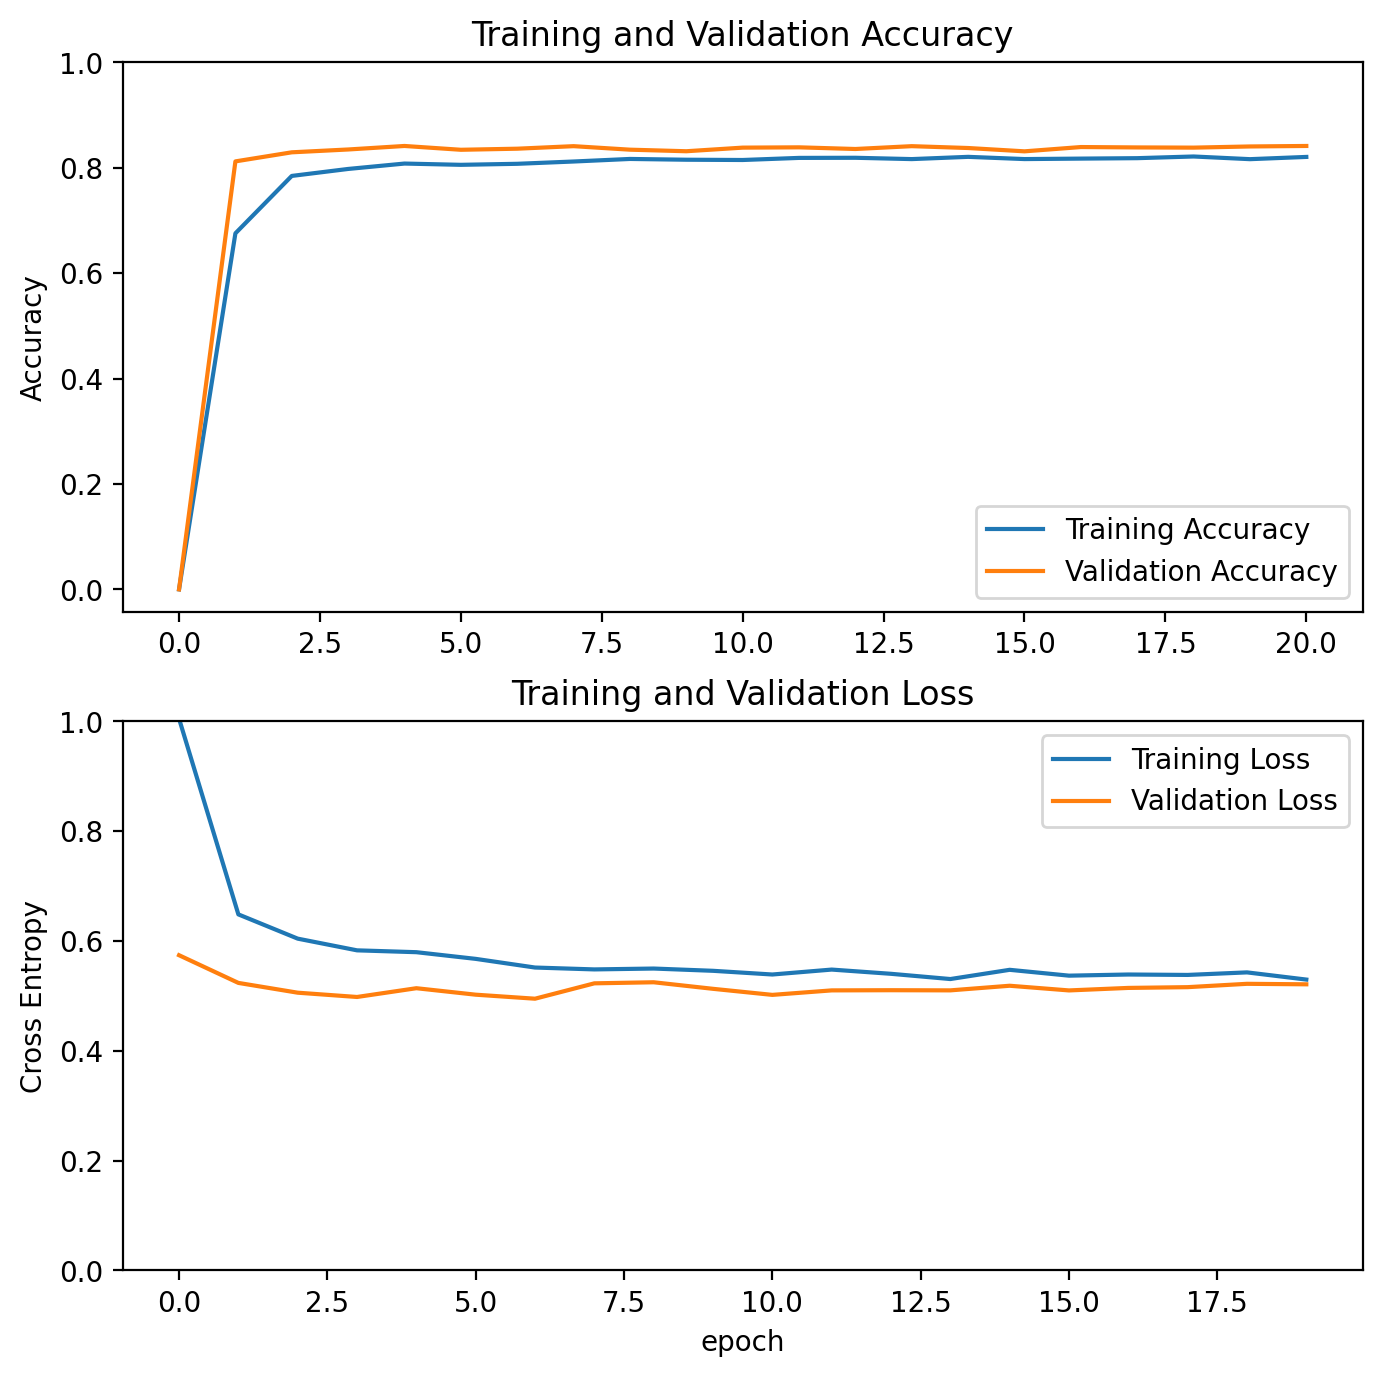

In [11]:
acc = [0.] + history.history['sparse_categorical_accuracy']
val_acc = [0.] + history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8), dpi=200)
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

With initial 20 epochs, the training accuracy and validation accuracy is 82.07% and 84.15% respectively, without any overfitting, but there is large avoidable bais ( as the original authors of paper has achieved 98.57% accuracy) which can be overcome by training the model for longer time and fine tuning the later layers.

<a name='3'></a>
## 3. Fine Tuning of Model

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen. The important takeaway is that the later layers are the part of your network that contain the fine details that are more specific to problem.

First, unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if accuracy improved!

In [12]:
base_model = model.layers[2]
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [13]:
fine_tune_at = 120

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = None

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 1280)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 1, 1, 1280)        0         
                                                                 
 flatten (Flatten)           (None, 1280)              0     

In [15]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss="sparse_categorical_crossentropy",
               metrics=["sparse_categorical_accuracy"]) #decrease the learning rate to achieve fine tuning

In [16]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 20/30
675/675 [==============================] - 159s 225ms/step - loss: 0.7067 - sparse_categorical_accuracy: 0.7649 - val_loss: 0.4126 - val_sparse_categorical_accuracy: 0.8581
Epoch 21/30
675/675 [==============================] - 150s 222ms/step - loss: 0.4447 - sparse_categorical_accuracy: 0.8533 - val_loss: 0.4244 - val_sparse_categorical_accuracy: 0.8619
Epoch 22/30
675/675 [==============================] - 145s 214ms/step - loss: 0.3866 - sparse_categorical_accuracy: 0.8715 - val_loss: 0.3099 - val_sparse_categorical_accuracy: 0.9028
Epoch 23/30
675/675 [==============================] - 145s 215ms/step - loss: 0.3463 - sparse_categorical_accuracy: 0.8858 - val_loss: 0.3137 - val_sparse_categorical_accuracy: 0.8972
Epoch 24/30
675/675 [==============================] - 146s 216ms/step - loss: 0.3068 - sparse_categorical_accuracy: 0.8950 - val_loss: 0.2915 - val_sparse_categorical_accuracy: 0.9065
Epoch 25/30
675/675 [==============================] - 145s 215ms/step - lo

In [17]:
acc += history_fine.history['sparse_categorical_accuracy']
val_acc += history_fine.history['val_sparse_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

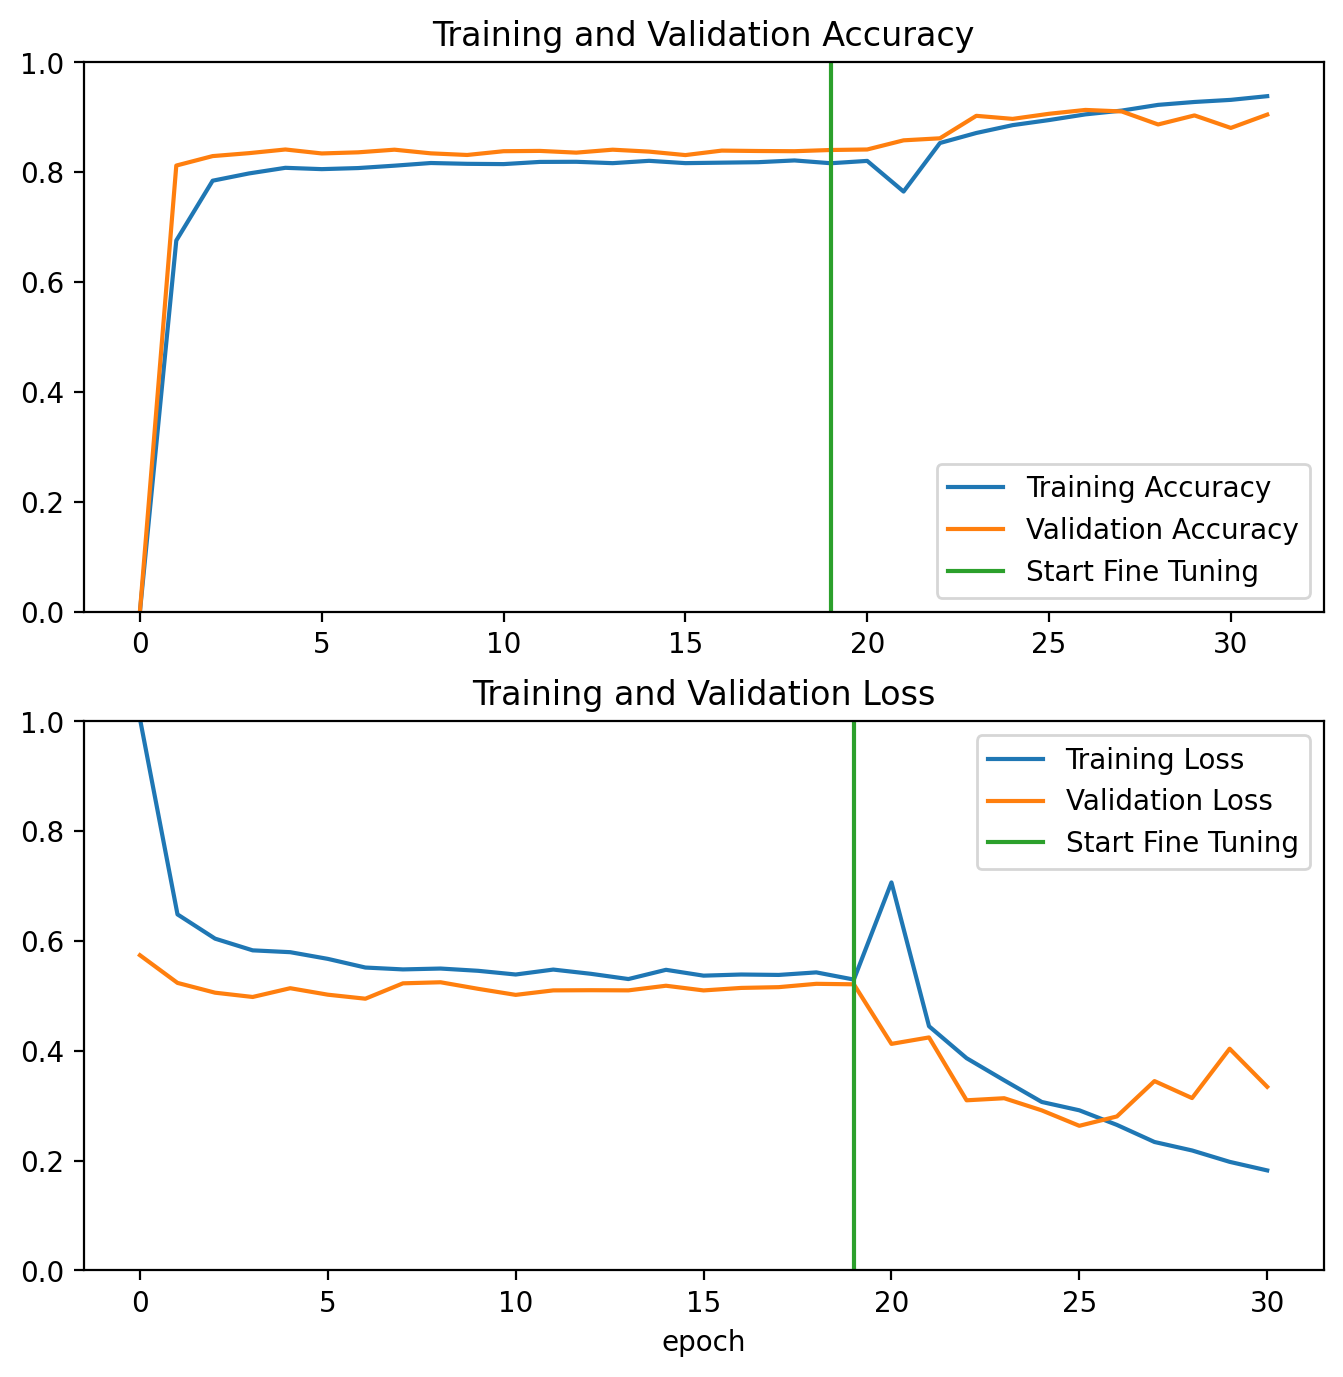

In [18]:
plt.figure(figsize=(8, 8), dpi = 200)
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

At 30 epochs after fine tuning and decreasing the learning, the training accuracy and validation accuracy is 93.86% and 90.50% respectively, with about 3% overfitting, but there is still avoidable bais which I will try to decrease by training model for more 10 epochs at same learing rate.

In [19]:
fine_tune_epochs_2 = 10
total_epochs =  epochs + fine_tune_epochs + fine_tune_epochs_2

history_fine_2 = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=val_ds)

Epoch 30/40
675/675 [==============================] - 158s 233ms/step - loss: 0.1804 - sparse_categorical_accuracy: 0.9397 - val_loss: 0.3246 - val_sparse_categorical_accuracy: 0.9070
Epoch 31/40
675/675 [==============================] - 168s 249ms/step - loss: 0.1632 - sparse_categorical_accuracy: 0.9453 - val_loss: 0.3043 - val_sparse_categorical_accuracy: 0.9154
Epoch 32/40
675/675 [==============================] - 167s 246ms/step - loss: 0.1477 - sparse_categorical_accuracy: 0.9518 - val_loss: 0.2828 - val_sparse_categorical_accuracy: 0.9269
Epoch 33/40
675/675 [==============================] - 162s 240ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.9529 - val_loss: 0.3288 - val_sparse_categorical_accuracy: 0.9146
Epoch 34/40
675/675 [==============================] - 173s 257ms/step - loss: 0.1372 - sparse_categorical_accuracy: 0.9548 - val_loss: 0.3561 - val_sparse_categorical_accuracy: 0.9094
Epoch 35/40
675/675 [==============================] - 169s 250ms/step - lo

In [20]:
acc += history_fine_2.history['sparse_categorical_accuracy']
val_acc += history_fine_2.history['val_sparse_categorical_accuracy']

loss += history_fine_2.history['loss']
val_loss += history_fine_2.history['val_loss']

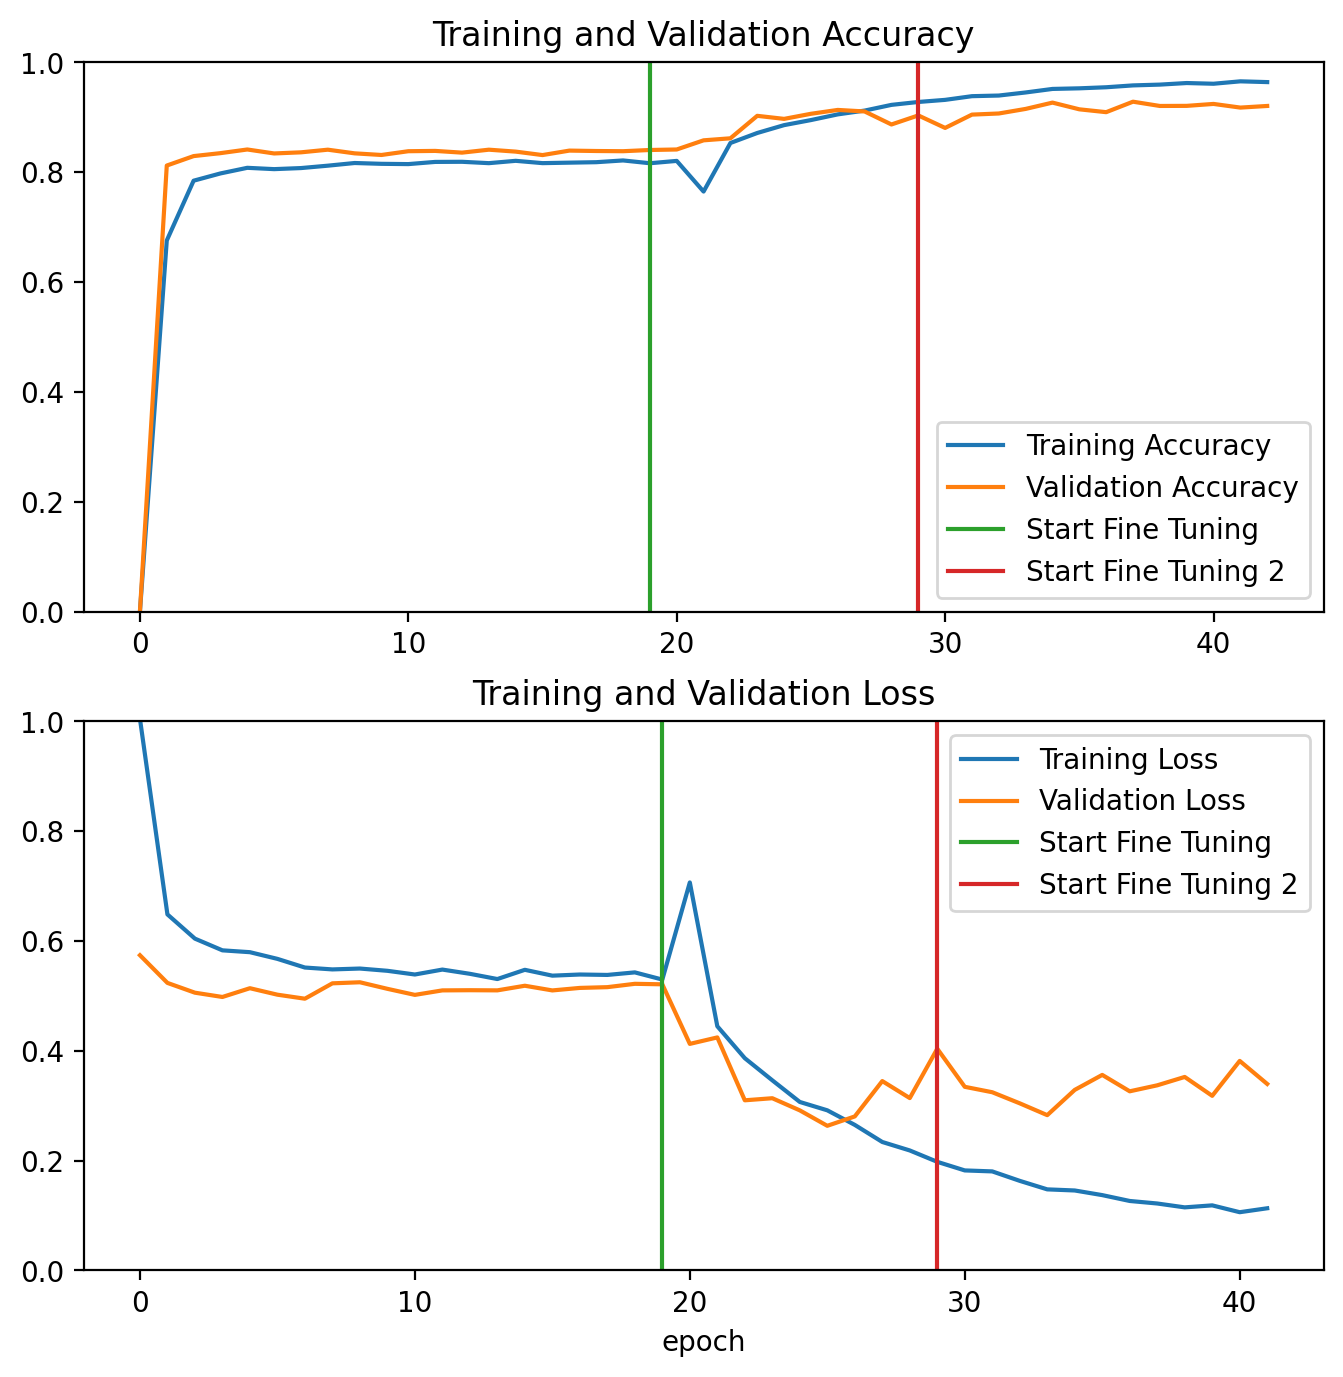

In [21]:
plt.figure(figsize=(8, 8), dpi =200)
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([epochs+fine_tune_epochs-1,epochs+fine_tune_epochs-1],
          plt.ylim(), label='Start Fine Tuning 2')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([epochs+fine_tune_epochs-1,epochs+fine_tune_epochs-1],
         plt.ylim(), label='Start Fine Tuning 2')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

The training accuracy and validation accuracy is 96.42% and 92.07% respectively after 40 epochs. Now the model is performing quide good with little avoidable bias and around 4% overfitting on training data.

<a name='4'></a>
## 4. Re-compiling again with lower learning rate

In [22]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),loss="sparse_categorical_crossentropy",
               metrics=["sparse_categorical_accuracy"])

In [23]:
fine_tune_epochs_3 = 10
total_epochs =  epochs + fine_tune_epochs + fine_tune_epochs_2 +fine_tune_epochs_3

history_fine_3 = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history_fine_2.epoch[-1],
                         validation_data=val_ds)

Epoch 40/50
675/675 [==============================] - 167s 235ms/step - loss: 0.0471 - sparse_categorical_accuracy: 0.9844 - val_loss: 0.3196 - val_sparse_categorical_accuracy: 0.9348
Epoch 41/50
675/675 [==============================] - 162s 240ms/step - loss: 0.0340 - sparse_categorical_accuracy: 0.9890 - val_loss: 0.3376 - val_sparse_categorical_accuracy: 0.9352
Epoch 42/50
675/675 [==============================] - 168s 248ms/step - loss: 0.0283 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.3781 - val_sparse_categorical_accuracy: 0.9331
Epoch 43/50
675/675 [==============================] - 157s 233ms/step - loss: 0.0262 - sparse_categorical_accuracy: 0.9919 - val_loss: 0.4070 - val_sparse_categorical_accuracy: 0.9335
Epoch 44/50
675/675 [==============================] - 151s 224ms/step - loss: 0.0225 - sparse_categorical_accuracy: 0.9927 - val_loss: 0.4225 - val_sparse_categorical_accuracy: 0.9317
Epoch 45/50
675/675 [==============================] - 152s 226ms/step - lo

In [24]:
acc += history_fine_3.history['sparse_categorical_accuracy']
val_acc += history_fine_3.history['val_sparse_categorical_accuracy']

loss += history_fine_3.history['loss']
val_loss += history_fine_3.history['val_loss']

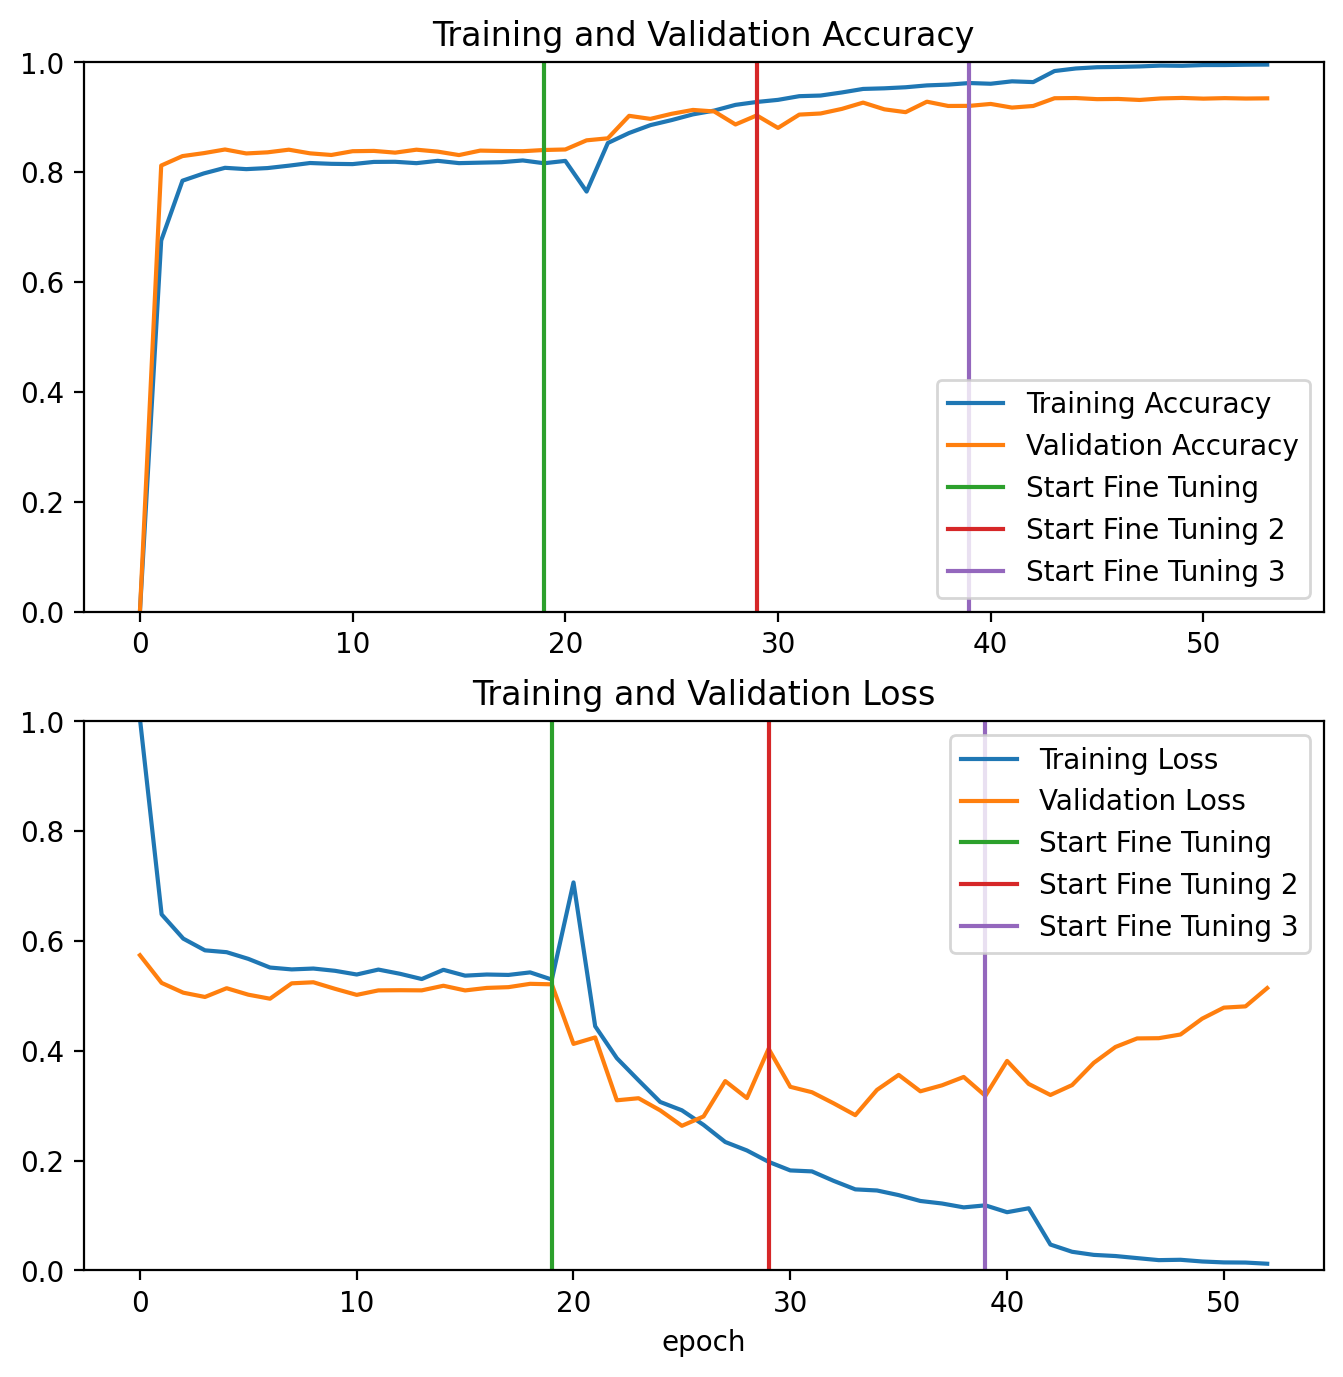

In [25]:
plt.figure(figsize=(8, 8), dpi = 200)
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([epochs+fine_tune_epochs-1,epochs+fine_tune_epochs-1],
          plt.ylim(), label='Start Fine Tuning 2')
plt.plot([total_epochs-fine_tune_epochs_3-1,total_epochs-fine_tune_epochs_3-1],
          plt.ylim(), label='Start Fine Tuning 3')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([epochs+fine_tune_epochs-1,epochs+fine_tune_epochs-1],
         plt.ylim(), label='Start Fine Tuning 2')
plt.plot([total_epochs-fine_tune_epochs_3-1,total_epochs-fine_tune_epochs_3-1],
          plt.ylim(), label='Start Fine Tuning 3')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

The accuracy of training and validation sets after 50 epochs is 99.61% and 93.44% with about 6% overfiiting on training data. This overfitting can be avoid by using larger dropout amount or by using augmentation on dataset while training. Overall MobileNetV2 has performed well on this EuroSat dataset with at par accuracy as of original paper authors. 

In [26]:
model.save("Eurosat_MN_e50_d004.h5")

<a name='5'></a>
## 5. References

1. Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.
2. Course 4 of Deep Learning Specialization by Andrew Ng

[Github profile](https://github.com/dineshgulati933)
You can find same notebook along with data augmentation on my github